In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
# Replace BASE_URL with your own
URMIL_BASE_URL = "/content/drive/MyDrive/APS360/APS360 Project/Dataset"
HIMANISH_BASE_URL = "/content/drive/MyDrive/UofT Third Year /APS 360/Project/APS360 Project/Dataset"
SAMREEN_BASE_URL = "/content/drive/MyDrive/APS360 Project/Dataset"
MIHIKA_BASE_URL = "/content/drive/MyDrive/3: third year/APS360/APS360 Project/Dataset"

BASE_URL = MIHIKA_BASE_URL

In [ ]:
!pip install pydub==0.25.1
!pip install librosa

In [ ]:
import numpy as np

from keras.layers import (Dense, Activation, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, GlobalAveragePooling2D)
from keras.models import Sequential, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from pydub import AudioSegment
import seaborn as sns
import librosa
import librosa.display

from collections import Counter
from enum import Enum
import os
import time
import pickle
import random


random.seed(0)
np.random.seed(12)

In [ ]:
class Genre(Enum):
  BLUES = 0
  CLASSICAL = 1
  COUNTRY = 2
  DISCO = 3
  HIPHOP = 4
  JAZZ = 5
  METAL = 6
  POP = 7
  REGGAE = 8
  ROCK = 9

def GenreNames():
  for i in Genre:
    yield i.name.lower()

CLASSES = [name.upper() for name in GenreNames()]

In [ ]:
def splitwavfiles(file_path):
  if not file_path.endswith("wav"):
    return None

  audio = AudioSegment.from_wav(file_path)
  duration = audio.duration_seconds

  for i in range(int(duration//3)):
    t1, t2 = i*3*1000, (i+1)*3*1000

    org_filename = file_path.split('/')[-1].split('.')[:-1]
    processed_folder_path = '/'.join(file_path.replace('raw', 'processed').split('/')[:-1])

    split_audio = audio[t1:t2]
    split_audio.export(os.path.join(processed_folder_path, f"{'.'.join(org_filename)}.{i}.wav"), format="wav")

def split_by_genre(genre, prepath=""):
  run = False
  for root, dirs, files in os.walk(f"{BASE_URL}{prepath}/raw/{genre}"):
    for name in files:
      if name.endswith("wav"):
        if not run:
          print('Processing', genre)
          run = True
        file_path = os.path.join(root, name)
        try:
          splitwavfiles(file_path)
        except Exception as e:
          print(file_path, "crashed")
          print(e)
  if not run:
    print(f"No processing needed for {genre}")
        
def split_all_genres(demo=False):
  prepath = ""
  if demo:
    prepath = "/demo"
  for genre in GenreNames():
    split_by_genre(genre, prepath)

In [ ]:
split_all_genres()

In [ ]:
# Quality Check
def check_duration(demo=False):

  prepath = "/processed_wav"
  if demo:
    prepath = "/demo/processed"
  
  for genre in GenreNames():
    run = False
    for root, dirs, files in os.walk(f"{BASE_URL}{prepath}/{genre}"):
      for name in files:
        if name.endswith("wav"):
          if not run:
            print('Processing', genre)
            run = True
          file_path = os.path.join(root, name)
          try:
            audio = AudioSegment.from_wav(file_path)
            duration = audio.duration_seconds

            if duration != 3:
              print(file_path, 'duration is', duration)
          except Exception as e:
            print(file_path, "crashed")
            print(e)
    if not run:
      print(f"No processing needed for {genre}")

In [ ]:
check_duration()

In [ ]:
# Librosa MFCC and store as pickle values
def get_mfcc(file_path):
  y, sr = librosa.load(file_path)
  """
  plt.figure(figsize=(12,4))
  librosa.display.waveshow(y, sr=sr, marker='.')
  plt.ylabel('Audio Waveform')
  """

  # Let's make and display a mel-scaled power (energy-squared) spectrogram
  S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

  # Convert to log scale (dB). We'll use the peak power as reference.
  log_S = librosa.amplitude_to_db(S, ref=np.max)
  """
  # Make a new figure
  plt.figure(figsize=(12,4))

  # Display the spectrogram on a mel scale
  # sample rate and hop length parameters are used to render the time axis
  librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

  # Put a descriptive title on the plot
  plt.title('mel power spectrogram')

  # draw a color bar
  plt.colorbar(format='%+02.0f dB')

  # Make the figure layout compact
  plt.tight_layout()
  """
  
  # Next, we'll extract the first 13 Mel-frequency cepstral coefficients (MFCCs)
  mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
  """
  # We'll show each in its own subplot
  plt.figure(figsize=(12, 6))

  plt.subplot(3,1,1)
  librosa.display.specshow(mfcc)
  plt.ylabel('MFCC')
  """
  
  # Check for shape
  if mfcc.shape != (13, 130):
    print(file_path, 'different shape', mfcc.shape)
  return mfcc

def convert_to_mfcc(demo=False):
  input_path = "/processed_wav"
  output_path = "/processed_pkl"
  if demo:
    input_path = "/demo/processed"
    output_path = "/demo/processed"

  for genre in GenreNames():
    mfccs = []
    run = False
    input_folder = f"{BASE_URL}{input_path}/{genre}"
    output_folder = f"{BASE_URL}{output_path}/{genre}"
    for root, dirs, files in os.walk(input_folder):
      for name in files:
        if name.endswith("wav"):
          if not run:
            print('Processing', genre)
            run = True
          file_path = os.path.join(root, name)
          try:
            mfcc = get_mfcc(file_path)
            mfccs.append(mfcc)
          except Exception as e:
            print(file_path, "crashed")
            print(e)
    if os.path.isdir(output_folder):
      with open(f"{output_folder}/mfcc.pkl", 'wb') as outfile:
        pickle.dump(mfccs, outfile)
    if not run:
      print(f"No processing needed for {genre}")

In [ ]:
convert_to_mfcc()

Processing blues
Processing classical
Processing country
Processing disco
Processing hiphop
Processing jazz
Processing metal
Processing pop
Processing reggae
Processing rock


In [ ]:
# Split Files into Test, Valid and Training
def split_pkl_data(genre):
  global label_train, label_valid, label_test, mfcc_train, mfcc_valid, mfcc_test

  with open(f"{BASE_URL}/processed_pkl/{genre}/mfcc.pkl", 'rb') as infile:
      data = pickle.load(infile)
  random.shuffle(data)

  train = data[:700]
  temp = [genre]*700
  label_train.extend(temp)
  valid = data[700:700+150]
  temp = [genre]*150
  label_valid.extend(temp)
  test = data[700+150:]
  temp = [genre]*(len(data[700+150:]))
  label_test.extend(temp)

  mfcc_train.extend(train)
  mfcc_valid.extend(valid)
  mfcc_test.extend(test)

def format_dataset():
  global label_train, label_valid, label_test, mfcc_train, mfcc_valid, mfcc_test, input_shape

  for genre in GenreNames():
    print('Processing', genre)
    split_pkl_data(genre)

  label_train = to_categorical(np.array([Genre[i.upper()].value for i in label_train]))
  label_valid = to_categorical(np.array([Genre[i.upper()].value for i in label_valid]))
  label_test = to_categorical(np.array([Genre[i.upper()].value for i in label_test]))

  mfcc_train = np.array(mfcc_train)
  mfcc_valid = np.array(mfcc_valid)
  mfcc_test = np.array(mfcc_test)

  input_shape = (mfcc_train.shape[1], mfcc_train.shape[2], 1)
  print(input_shape)

  mfcc_train = mfcc_train.reshape(mfcc_train.shape[0], mfcc_train.shape[1], mfcc_train.shape[2], 1)
  print(mfcc_train.shape)
  mfcc_valid = mfcc_valid.reshape(mfcc_valid.shape[0], mfcc_valid.shape[1], mfcc_valid.shape[2], 1)
  print(mfcc_valid.shape)
  mfcc_test = mfcc_test.reshape(mfcc_test.shape[0], mfcc_test.shape[1], mfcc_test.shape[2], 1)
  print(mfcc_test.shape)

In [ ]:
label_train, label_valid, label_test = [], [], []
mfcc_train, mfcc_valid, mfcc_test = [], [], []

format_dataset()

Processing blues
Processing classical
Processing country
Processing disco
Processing hiphop
Processing jazz
Processing metal
Processing pop
Processing reggae
Processing rock
(13, 130, 1)
(7000, 13, 130, 1)
(1500, 13, 130, 1)
(1481, 13, 130, 1)


CNN - Primary Model

Epoch 1/100
219/219 [==============================] - 11s 5ms/step - loss: 3.1942 - acc: 0.2087 - val_loss: 1.9849 - val_acc: 0.2480
Epoch 2/100
219/219 [==============================] - 1s 4ms/step - loss: 1.8962 - acc: 0.2891 - val_loss: 1.7665 - val_acc: 0.3240
Epoch 3/100
219/219 [==============================] - 1s 4ms/step - loss: 1.7567 - acc: 0.3324 - val_loss: 1.6619 - val_acc: 0.3660
Epoch 4/100
219/219 [==============================] - 1s 4ms/step - loss: 1.6859 - acc: 0.3683 - val_loss: 1.5773 - val_acc: 0.4107
Epoch 5/100
219/219 [==============================] - 1s 4ms/step - loss: 1.6259 - acc: 0.3956 - val_loss: 1.5875 - val_acc: 0.4140
Epoch 6/100
219/219 [==============================] - 1s 4ms/step - loss: 1.5833 - acc: 0.4144 - val_loss: 1.5381 - val_acc: 0.4487
Epoch 7/100
219/219 [==============================] - 1s 4ms/step - loss: 1.5432 - acc: 0.4366 - val_loss: 1.5244 - val_acc: 0.4440
Epoch 8/100
219/219 [==============================] - 1s 4ms/step -

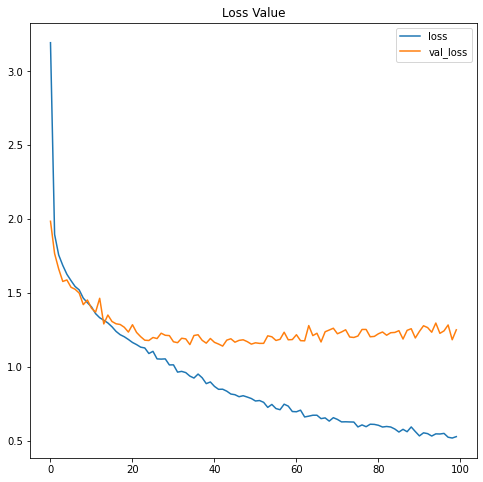

acc: 0.8154285550117493
val_acc: 0.6233333349227905


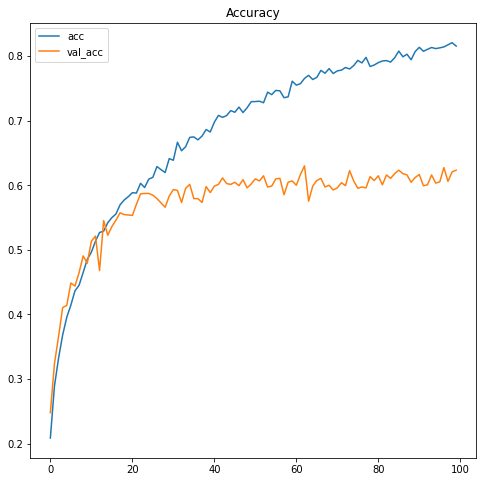

Test: 0.605671823


In [ ]:
model = Sequential()
model.add(Conv2D(32, (4, 4), activation='relu', strides=(2, 2), 
    padding='same', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (4, 4), activation='relu', strides=(2, 2), 
    padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
     optimizer='adam',
     metrics=['acc'])

# Training the model
history = model.fit(mfcc_train, label_train, epochs=100, validation_data=(mfcc_valid, label_valid))

# Displaying loss values
plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()

# Displaying accuracy scores
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

_, test_acc = model.evaluate(mfcc_test, label_test, verbose=0)
print('Test: %.9f' % (test_acc))

Epoch 1/30
219/219 [==============================] - 5s 19ms/step - loss: 2.1940 - acc: 0.3051 - val_loss: 2.0048 - val_acc: 0.3087
Epoch 2/30
219/219 [==============================] - 4s 19ms/step - loss: 1.7602 - acc: 0.4009 - val_loss: 1.8937 - val_acc: 0.3347
Epoch 3/30
219/219 [==============================] - 4s 19ms/step - loss: 1.5340 - acc: 0.4570 - val_loss: 1.7191 - val_acc: 0.4287
Epoch 4/30
219/219 [==============================] - 3s 14ms/step - loss: 1.3884 - acc: 0.5109 - val_loss: 1.4900 - val_acc: 0.4807
Epoch 5/30
219/219 [==============================] - 3s 13ms/step - loss: 1.2991 - acc: 0.5414 - val_loss: 1.7360 - val_acc: 0.4673
Epoch 6/30
219/219 [==============================] - 3s 13ms/step - loss: 1.2110 - acc: 0.5787 - val_loss: 1.3369 - val_acc: 0.5387
Epoch 7/30
219/219 [==============================] - 3s 13ms/step - loss: 1.1660 - acc: 0.5954 - val_loss: 1.3667 - val_acc: 0.5320
Epoch 8/30
219/219 [==============================] - 3s 13ms/step - 

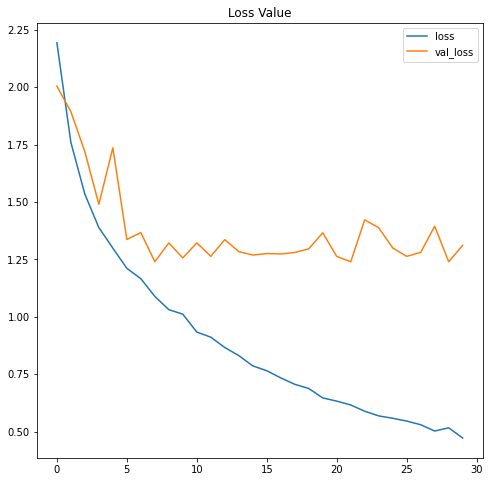

acc: 0.8418571352958679
val_acc: 0.5853333473205566


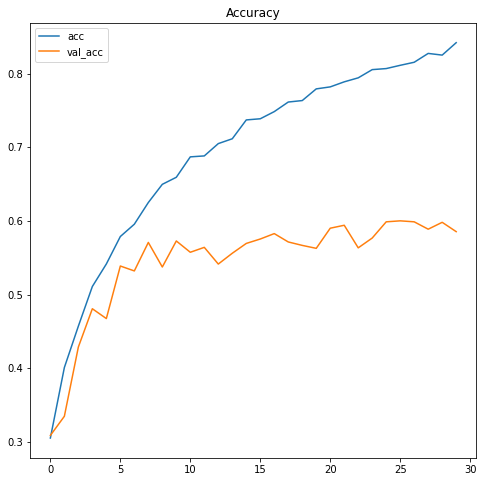

Test: 0.590141773


In [ ]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(2,2),strides=(1,1), input_shape=input_shape))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,kernel_size=(2,2),strides = (1,1)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dropout(rate=0.3))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
     optimizer='adam',
     metrics=['acc'])

# Training the model
history = model.fit(mfcc_train, label_train, epochs=30, validation_data=(mfcc_valid, label_valid))

# Displaying loss values
plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()

# Displaying accuracy scores
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

_, test_acc = model.evaluate(mfcc_test, label_test, verbose=0)
print('Test: %.9f' % (test_acc))


Epoch 1/200
219/219 [==============================] - 2s 7ms/step - loss: 3.6371 - acc: 0.2346 - val_loss: 1.8098 - val_acc: 0.3380
Epoch 2/200
219/219 [==============================] - 1s 5ms/step - loss: 1.7663 - acc: 0.3441 - val_loss: 1.6797 - val_acc: 0.3787
Epoch 3/200
219/219 [==============================] - 1s 5ms/step - loss: 1.5986 - acc: 0.4081 - val_loss: 1.5996 - val_acc: 0.4220
Epoch 4/200
219/219 [==============================] - 1s 5ms/step - loss: 1.4854 - acc: 0.4577 - val_loss: 1.4809 - val_acc: 0.4520
Epoch 5/200
219/219 [==============================] - 1s 5ms/step - loss: 1.3929 - acc: 0.4893 - val_loss: 1.3844 - val_acc: 0.4973
Epoch 6/200
219/219 [==============================] - 1s 5ms/step - loss: 1.3142 - acc: 0.5211 - val_loss: 1.3683 - val_acc: 0.4980
Epoch 7/200
219/219 [==============================] - 1s 5ms/step - loss: 1.2150 - acc: 0.5576 - val_loss: 1.3674 - val_acc: 0.5020
Epoch 8/200
219/219 [==============================] - 1s 5ms/step - 

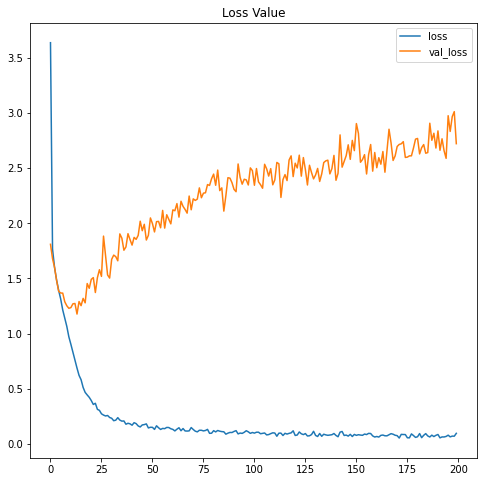

acc: 0.9725714325904846
val_acc: 0.5839999914169312


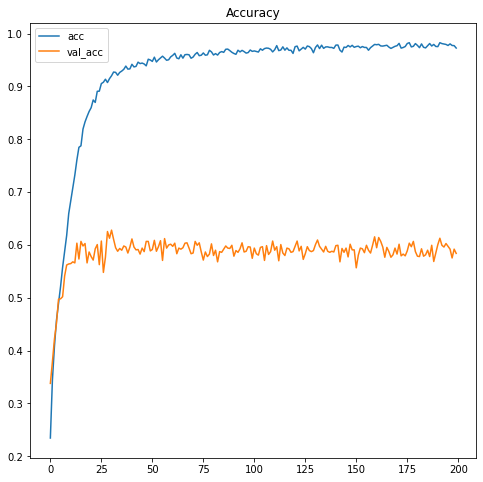

Test: 0.590817034


In [ ]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation='relu',
    padding='same', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (2, 2), activation='relu',
    padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (2, 2), activation='relu',
    padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
     optimizer='adam',
     metrics=['acc'])

# Training the model
history = model.fit(mfcc_train, label_train, epochs=200, validation_data=(mfcc_valid, label_valid))

# Displaying loss values
plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()

# Displaying accuracy scores
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

_, test_acc = model.evaluate(mfcc_test, label_test, verbose=0)
print('Test: %.9f' % (test_acc))

In [ ]:
def build_model(input_shape):
  model = Sequential([
    Conv2D(32, (3, 3), activation='relu',
      padding='valid', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu',
        padding='valid'),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.25),
    Conv2D(128, (2, 2), activation='relu',
        padding='valid'),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='softmax')       
  ])

  return model

def train_model(model, input_shape, lr=0.01, batch_size=32, epochs=80):
  optimizer = optimizers.Adam(learning_rate=lr)
  model.build(input_shape)
  model.compile(loss='categorical_crossentropy', 
      optimizer=optimizer,
      metrics=['acc'])

  model.summary()
  
  history = model.fit(mfcc_train, label_train, epochs=epochs, validation_data=(mfcc_valid, label_valid), batch_size=batch_size)

  return history

def plt_model_training(history):
  # Displaying loss values
  plt.figure(figsize=(8,8))
  plt.title('Loss Value')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['loss', 'val_loss'])
  print('loss:', history.history['loss'][-1])
  print('val_loss:', history.history['val_loss'][-1])
  plt.show()

  # Displaying accuracy scores
  plt.figure(figsize=(8,8))
  plt.title('Accuracy')
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.legend(['acc', 'val_acc'])
  print('acc:', history.history['acc'][-1])
  print('val_acc:', history.history['val_acc'][-1])
  plt.show()

def eval_model(model):
  for i in [(mfcc_train, label_train, 'train'),
            (mfcc_valid, label_valid, 'valid'),
            (mfcc_test, label_test, 'test')]:
    _, acc = model.evaluate(i[0], i[1], verbose=0)
    print(f"{i[2].title()} accuracy: {acc}")

def predict_model(model, data=mfcc_test.reshape(mfcc_test.shape[0], mfcc_test.shape[1], mfcc_test.shape[2]), labels=label_test):
  predictions = model.predict(data)
  labels = np.argmax(labels, axis=1)
  predictions = np.argmax(predictions, axis=1)
  ans = accuracy_score(labels, predictions, normalize=True, sample_weight=None)

  return predictions, labels, ans

def cf_matrix(predictions, labels):
  
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(10,10))
  classes=[i.name for i in Genre]

  sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, fmt='d', cmap=plt.cm.Blues, cbar=False)
  plt.xlabel('Predicted Label')
  plt.ylabel('Actual Label')
  plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 128, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 64, 32)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5, 64, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 62, 128)        36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 31, 128)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 2, 31, 128)        0

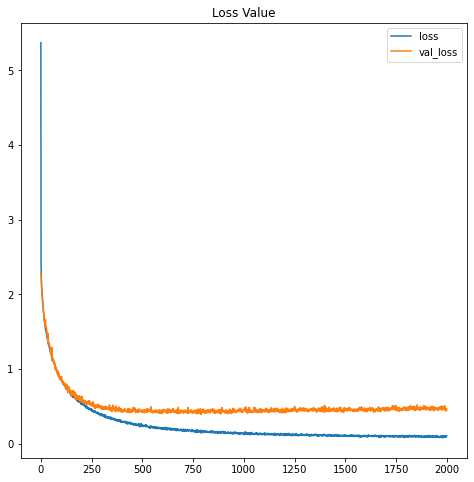

acc: 0.9651428461074829
val_acc: 0.8826666474342346


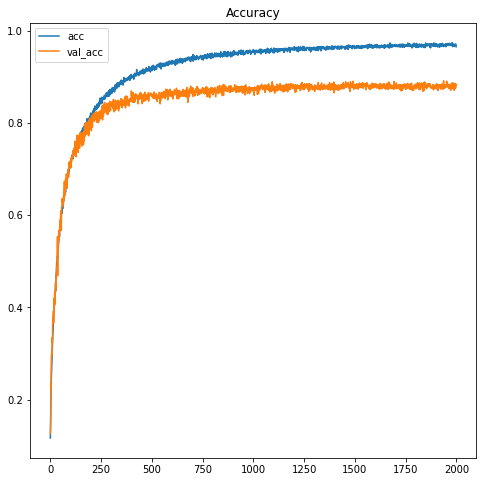

train: 0.9990000128746033
valid: 0.8826666474342346
test: 0.8858879208564758
Testing accuracy =  0.8858879135719109


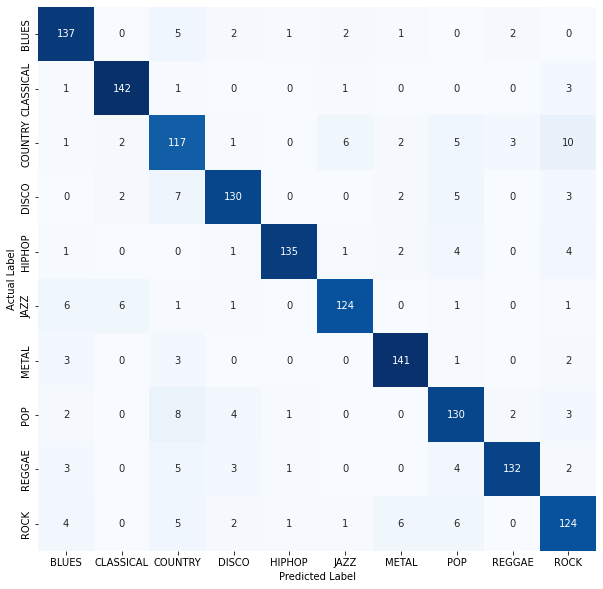

In [ ]:

model = build_model(input_shape)
history = train_model(model, input_shape, 0.0001, 32, 2000)
plt_model_training(history)
eval_model(model)
cf_matrix(model)


In [ ]:
# model.save("/content/drive/MyDrive/APS360/APS360 Project/my_model.h5")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 11, 128, 32)       320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 5, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 5, 64, 32)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 62, 128)        36992     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 2, 31, 128)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 2, 31, 128)       

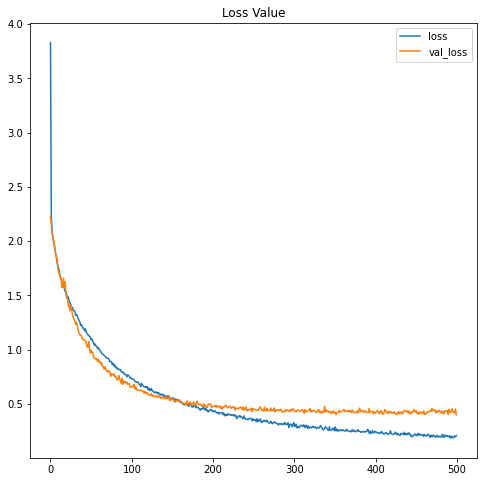

acc: 0.9292857050895691
val_acc: 0.875333309173584


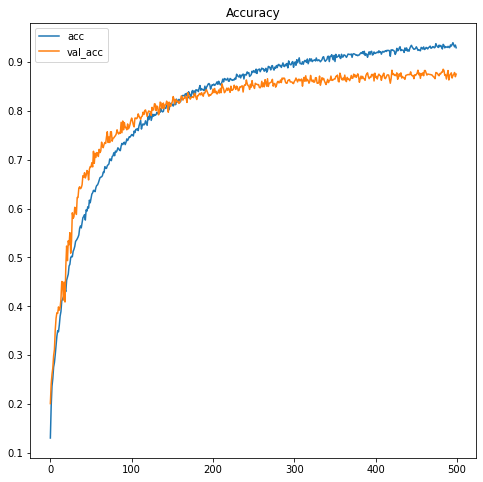

Train accuracy: 0.9980000257492065
Valid accuracy: 0.875333309173584
Test accuracy: 0.8852127194404602


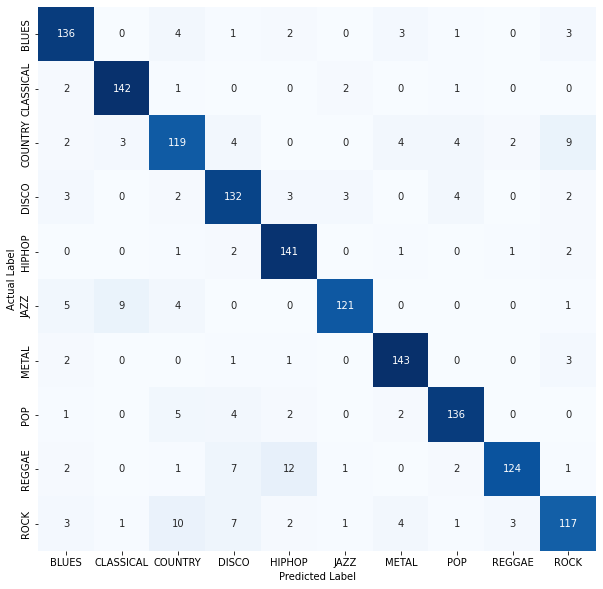

In [ ]:
model = build_model(input_shape)
history = train_model(model, input_shape, 0.0002, 64, 500)
plt_model_training(history)
eval_model(model)
predictions, labels, _ = predict_model(model)
cf_matrix(predictions, labels)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 11, 128, 32)       320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 64, 32)        0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 5, 64, 32)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 62, 128)        36992     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 2, 31, 128)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 2, 31, 128)       

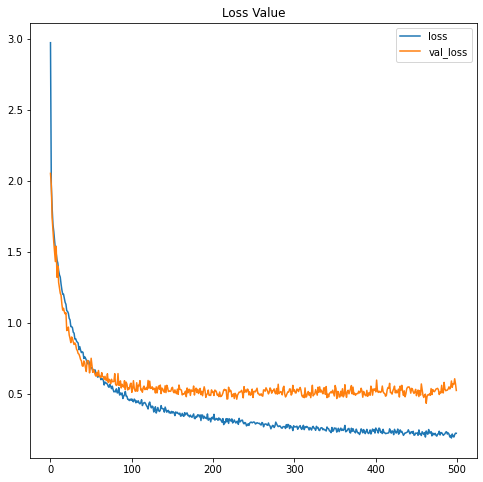

acc: 0.9274285435676575
val_acc: 0.862666666507721


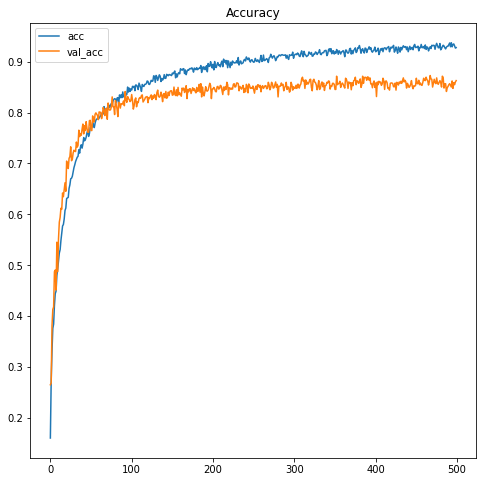

Train accuracy: 0.9985714554786682
Valid accuracy: 0.862666666507721
Test accuracy: 0.8663065433502197


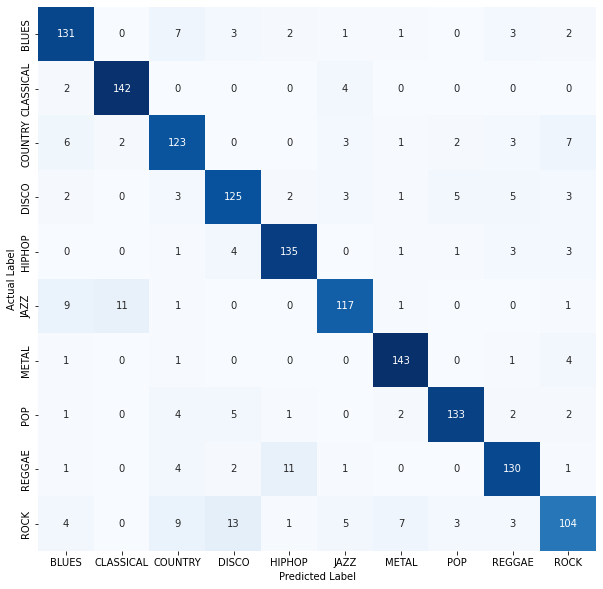

In [ ]:
model = build_model(input_shape)
history = train_model(model, input_shape, 0.001, 64, 500)
plt_model_training(history)
eval_model(model)
predictions, labels, _ = predict_model(model)
cf_matrix(predictions, labels)

In [ ]:
model = load_model("/content/drive/MyDrive/APS360/APS360 Project/my_model.h5")

Train accuracy: 0.99528568983078
Valid accuracy: 0.8913333415985107
Test accuracy: 0.8946657776832581


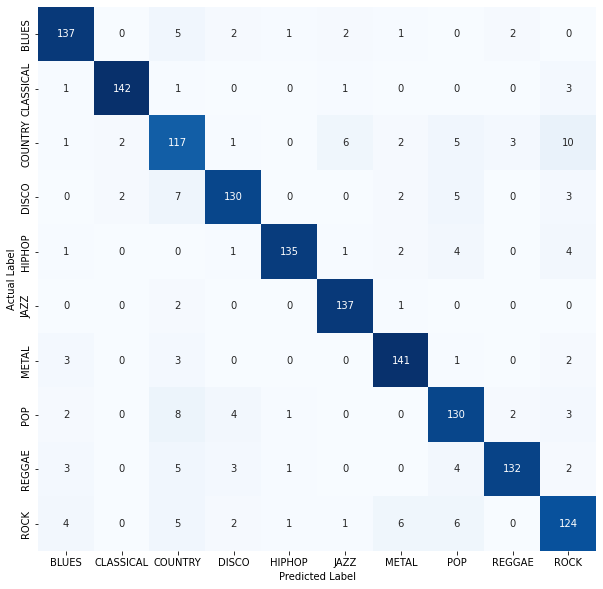

In [ ]:
eval_model(model)
pred, labels, ans = predict_model(model)
cf_matrix(pred, labels)

In [ ]:
def demo_predictions():
  predictions = []
  labels = []
  for genre in Genre:
    path = f"{BASE_URL}/demo/processed/{genre.name.lower()}/mfcc.pkl"

    if not os.path.exists(path):
      continue

    with open(path, 'rb') as infile:
      data = pickle.load(infile)
      
    label = to_categorical(np.array([genre.value for i in data] + [i.value for i in Genre]))
    label = np.delete(label, [i for i in range(len(data), len(label), 1)], axis=0)
    data = np.array(data)

    prediction, _, _ = predict_model(model, data, label)

    predicted_index = max(set(prediction), key=list(prediction).count)
    print(f"Predicting a {genre} song as {Genre(predicted_index).name} with {100*Counter(prediction)[predicted_index]/len(prediction):.3f} % certainty")
    
    predictions.extend(list(prediction))
    labels.extend(list(label))

  labels = np.argmax(labels, axis=1)
  ans = accuracy_score(labels, predictions, normalize=True, sample_weight=None)
  print(f"Overall accuracy of {100*ans:.3f} %")

  cf_matrix(predictions, labels)

def demo():
  split_all_genres(demo=True)
  print()
  check_duration(demo=True)
  print()
  convert_to_mfcc(demo=True)
  print()
  demo_predictions()

Predicting a Genre.CLASSICAL song as CLASSICAL with 94.231 % certainty
Predicting a Genre.COUNTRY song as POP with 40.385 % certainty
Predicting a Genre.HIPHOP song as HIPHOP with 92.308 % certainty
Predicting a Genre.METAL song as METAL with 98.077 % certainty
Predicting a Genre.POP song as POP with 88.462 % certainty
Predicting a Genre.ROCK song as ROCK with 67.308 % certainty
Overall accuracy of 77.244 %


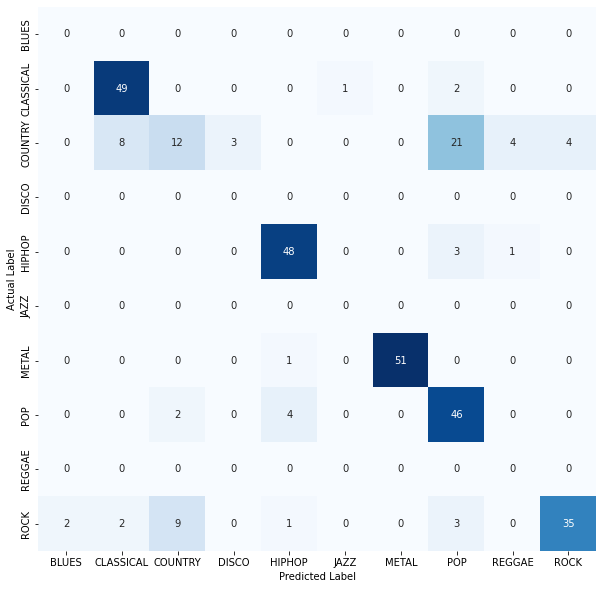

In [ ]:
demo_predictions()